# Modeling and Simulation in Python

Chapter 8: Pharmacokinetics

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
df = pd.read_csv('glucose_insulin.csv', index_col='time')
df

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


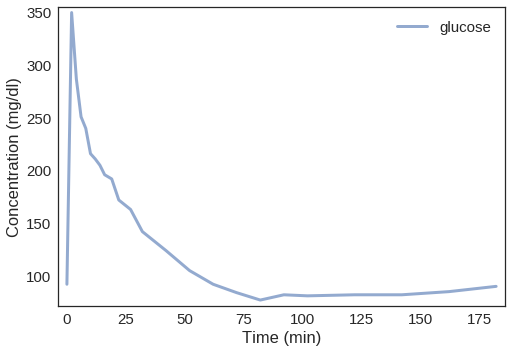

In [3]:
plot(df.glucose, label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dl)')

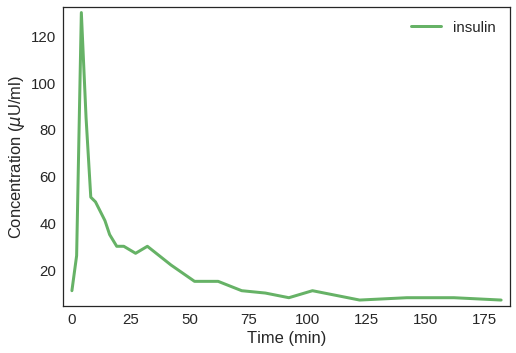

In [4]:
plot(df.insulin, color='green', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/ml)')

In [5]:
k1 = 0.0265
k2 = 1.28e-05
k3 = 0.0254
G0 = 279

In [6]:
S_t = k2 / k3
S_t

0.0005039370078740158

In [7]:
init = State(G=G0, X=0)

In [8]:
system = System(init=init, k1=k1, k2=k2, k3=k3,
                G_b = df.glucose[0],
                I_b = df.insulin[0],
                I = df.insulin,
                t0=0, t_end=182, dt=2)

In [9]:
def update_func(state, t, system):
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - G_b) - X*G
    dXdt = k2 * (I[t] - I_b) - k3 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [10]:
update_func(init, 0, system)

,value
G,269.089
X,0.000


In [11]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    df = TimeFrame(columns=system.init.index)
    df.loc[t0] = system.init
    
    for t in arange(t0, t_end, dt):
        df.loc[t+dt] = update_func(df.loc[t], t, system)
    
    system.results = df

In [12]:
# this generates KeyError: 18 because we don't have
# data at t=18

#run_simulation(system, update_func)

In [13]:
from scipy.interpolate import interp1d

def interpolate(series, **options):
    underride(options, fill_value='extrapolate')
    return interp1d(series.index, series.values, **options)

In [14]:
I_interp = interpolate(I)
I_interp

In [15]:
I_interp(18)

array(31.666666666666668)

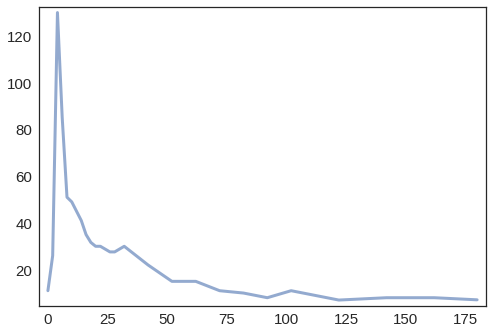

In [16]:
ts = arange(0, 182, 2)
Is = I_interp(ts)
plot(ts, Is)

In [17]:
system = System(init=init, k1=k1, k2=k2, k3=k3,
                G_b = df.glucose[0],
                I_b = df.insulin[0],
                I_interp = interpolate(df.insulin),
                t0=0, t_end=182, dt=2)

In [18]:
def update_func(state, t, system):
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - G_b) - X*G
    dXdt = k2 * (I_interp(t) - I_b) - k3 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [19]:
run_simulation(system, update_func)

In [20]:
system.results

,G,X
0,279,0
2,269.089,0
4,259.703,0.000384
6,250.616,0.00341089
8,240.499,0.00513202
10,230.16,0.00589531
12,220.124,0.00656863
14,210.442,0.00710534
16,201.174,0.00751239
18,192.365,0.00774516


In [21]:
def slope_func(state, t, system):
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - G_b) - X*G
    dXdt = k2 * (I_interp(t) - I_b) - k3 * X
    
    return dGdt, dXdt

In [22]:
slope_func(init, 0, system)

(-4.9554999999999998, 0.0)

In [23]:
from scipy.integrate import odeint

In [24]:
ts = df.index
args = system,
array = odeint(slope_func, init, ts, args)

In [25]:
results = TimeFrame(array, columns=init.index, index=ts)
results

,G,X
time,,
0,279.000000,0.000000
2,269.313178,0.000189
4,259.741164,0.001863
6,249.531357,0.004174
8,239.087517,0.005387
10,228.875898,0.006093
12,219.018111,0.006690
14,209.568047,0.007157
16,200.572093,0.007475


In [26]:
def plot_results(G, X, **options):
    plot(G, label='glucose', color='blue', **options)
    plot(X, label='interstitial insulin', color='green', **options)

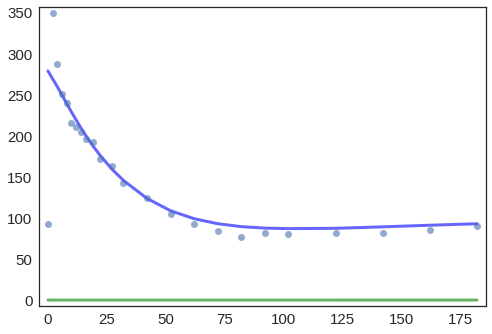

In [27]:
plot_results(results.G, results.X)
plot(df.glucose, style='o')

In [28]:
def run_odeint(system, slope_func):
    """Runs a simulation of the system.
    
    Adds a DataFrame to the System: results
    
    system: System object
    slope_func: function that computes slopes
    """
    unpack(system)

    ts = df.index
    args = system,
    array = odeint(slope_func, init, ts, args)

    system.results = TimeFrame(array, columns=init.index, index=ts)

In [29]:
run_odeint(system, slope_func)

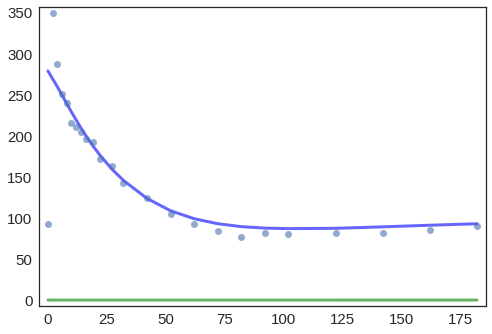

In [30]:
plot_results(results.G, results.X)
plot(df.glucose, style='o')

In [31]:
from scipy.optimize import curve_fit

In [32]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

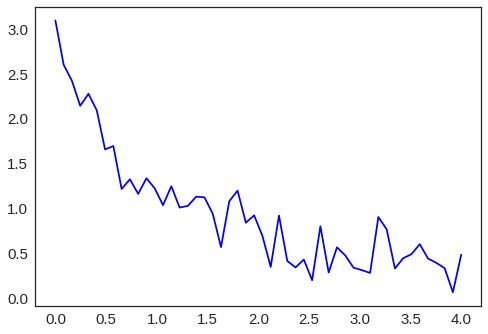

In [33]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

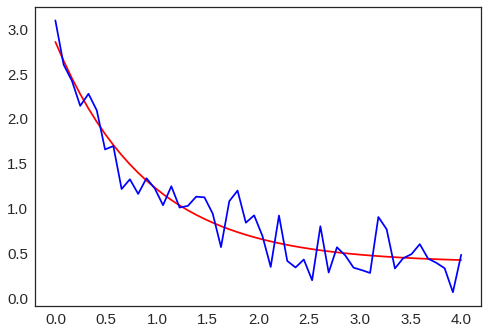

In [34]:
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.plot(xdata, ydata, 'b-', label='data')

In [35]:
popt

array([ 2.45957204,  1.10072009,  0.3946318 ])

In [36]:
def make_system(G0, k1, k2, k3):
    init = State(G=G0, X=0)
    system = System(init=init, k1=k1, k2=k2, k3=k3,
                    G_b = df.glucose[0],
                    I_b = df.insulin[0],
                    I_interp = interpolate(df.insulin),
                    t0=0, t_end=182)
    return system

In [37]:
def min_func(ts, G0, k1, k2, k3):
    print(G0, k1, k2, k3)
    system = make_system(G0, k1, k2, k3)
    run_odeint(system, slope_func)
    return system.results.G

In [38]:
series = min_func(ts, G0, k1, k2, k3)
series.shape

279 0.0265 1.28e-05 0.0254


(24,)

In [39]:
params = [G0, k1, k2, k3]
params

[279, 0.0265, 1.28e-05, 0.0254]

In [40]:
popt, pcov = curve_fit(min_func, df.glucose.index, df.glucose.values, p0=params)

279.0 0.0265 1.28e-05 0.0254
279.0 0.0265 1.28e-05 0.0254
279.0 0.0265 1.28e-05 0.0254
279.000004157 0.0265 1.28e-05 0.0254
279.0 0.0265000003949 1.28e-05 0.0254
279.0 0.0265 1.28000001907e-05 0.0254
279.0 0.0265 1.28e-05 0.0254000003785
264.927903125 0.0265513723974 1.34403293831e-05 0.0245950723502
264.927907073 0.0265513723974 1.34403293831e-05 0.0245950723502
264.927903125 0.026551372793 1.34403293831e-05 0.0245950723502
264.927903125 0.0265513723974 1.34403295834e-05 0.0245950723502
264.927903125 0.0265513723974 1.34403293831e-05 0.0245950727166
249.838330487 0.00942762407766 1.35816454292e-05 0.0268603341964
261.079805078 0.0228950056142 1.34929244289e-05 0.0226218293116
261.079808969 0.0228950056142 1.34929244289e-05 0.0226218293116
261.079805078 0.0228950059554 1.34929244289e-05 0.0226218293116
261.079805078 0.0228950056142 1.34929246299e-05 0.0226218293116
261.079805078 0.0228950056142 1.34929244289e-05 0.0226218296487
260.624239119 0.0229210084679 1.34867707034e-05 0.02264530

In [41]:
G0, k1, k2, k3 = popt

S_G = k1
S_t = k2 / k3

S_G, S_t

(0.022914611044078707, 0.00060473927935933815)

In [42]:
system = make_system(G0, k1, k2, k3)
run_odeint(system, slope_func)

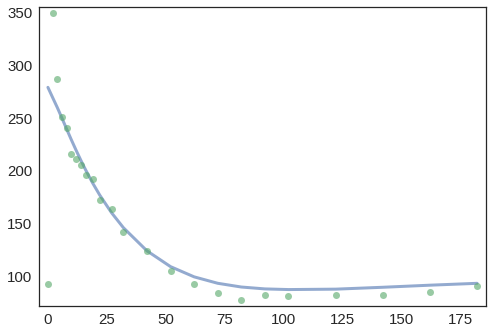

In [43]:
plot(results.G)
plot(df.glucose, style='o')

**Exercise:**

In [44]:
I0 = 363
k = 0.267
gamma = 0.0041
G_T = 83.7

In [45]:
def make_system(I0, k, gamma, G_T):
    init = State(I=I0)
    system = System(init=init, k=k, gamma=gamma, G_T=G_T,
                    G_interp = interpolate(df.glucose),
                    t0=0, t_end=182)
    return system

In [46]:
system = make_system(I0, k, gamma, G_T)
system

,value
init,I 363 dtype: int64
k,0.267
gamma,0.0041
G_T,83.7
G_interp,<scipy.interpolate.interpolate.interp1d object...
t0,0
t_end,182


In [47]:
def slope_func(state, t, system):
    I = state
    unpack(system)
    
    G = G_interp(t)
    if G > G_T:
        dIdt = gamma * (G - G_T) * (t - t0) - k * I
    else:
        dIdt = -k * I
    
    return dIdt

In [48]:
slope_func(init, 0, system)

G   -69.583099
X     0.000000
dtype: float64

In [49]:
def run_odeint(system, slope_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    slope_func: function that computes slopes
    """
    unpack(system)

    ts = df.index
    args = system,
    array = odeint(slope_func, init, ts, args)

    system.results= TimeFrame(array, columns=init.index, index=ts)

In [50]:
run_odeint(system, slope_func)
system.results

,I
time,
0,3.630000e+02
2,2.141086e+02
4,1.300092e+02
6,8.212017e+01
8,5.539686e+01
10,4.072261e+01
12,3.299744e+01
14,2.965294e+01
16,2.853345e+01


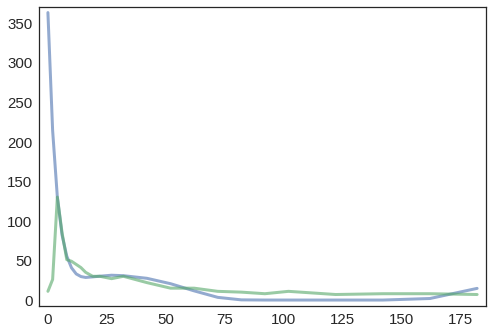

In [51]:
plot(system.results)
plot(df.insulin)

In [52]:
def min_func(ts, I0, k, gamma, G_T):
    print(I0, k, gamma, G_T)
    system = make_system(I0, k, gamma, G_T)
    run_odeint(system, slope_func)
    return system.results.I

In [53]:
min_func(ts, I0, k, gamma, G_T)

363 0.267 0.0041 83.7


time
0      3.630000e+02
2      2.141086e+02
4      1.300092e+02
6      8.212017e+01
8      5.539686e+01
10     4.072261e+01
12     3.299744e+01
14     2.965294e+01
16     2.853345e+01
19     2.928078e+01
22     3.009001e+01
27     3.134674e+01
32     3.077211e+01
42     2.744958e+01
52     2.064713e+01
62     1.160659e+01
72     3.398421e+00
82     2.367167e-01
92     1.639316e-02
102    1.135262e-03
122    5.444544e-06
142    2.582852e-08
162    1.950625e+00
182    1.474038e+01
Name: I, dtype: float64

In [54]:
params = [I0, k, gamma, G_T]
params

[363, 0.267, 0.0041, 83.7]

In [55]:
popt, pcov = curve_fit(min_func, df.insulin.index, df.insulin.values, p0=params)

363.0 0.267 0.0041 83.7
363.0 0.267 0.0041 83.7
363.0 0.267 0.0041 83.7
363.000005409 0.267 0.0041 83.7
363.0 0.267000003979 0.0041 83.7
363.0 0.267 0.00410000006109 83.7
363.0 0.267 0.0041 83.7000012472
52.1407032657 0.219014348394 0.00618331211343 93.2880126745
52.1407040427 0.219014348394 0.00618331211343 93.2880126745
52.1407032657 0.219014351657 0.00618331211343 93.2880126745
52.1407032657 0.219014348394 0.00618331220557 93.2880126745
52.1407032657 0.219014348394 0.00618331211343 93.2880140646
52.6449165662 0.165287894275 0.0063191630071 106.479964299
52.6449173506 0.165287894275 0.0063191630071 106.479964299
52.6449165662 0.165287896738 0.0063191630071 106.479964299
52.6449165662 0.165287894275 0.00631916310126 106.479964299
52.6449165662 0.165287894275 0.0063191630071 106.479965886
56.9034467762 0.165536100667 0.00543292231588 106.885457012
56.9034476241 0.165536100667 0.00543292231588 106.885457012
56.9034467762 0.165536103134 0.00543292231588 106.885457012
56.9034467762 0.1655

In [56]:
I0, k, gamma, G_T = popt

In [57]:
system = make_system(*popt)

In [58]:
run_odeint(system, slope_func)

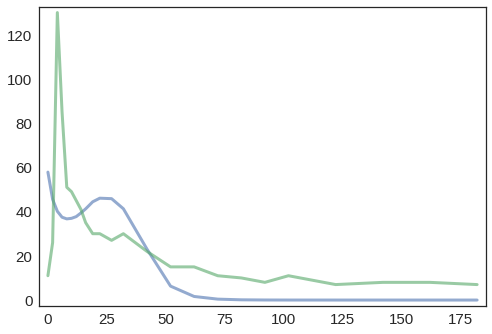

In [59]:
plot(system.results)
plot(df.insulin)

In [60]:
I_max = df.insulin.max()
I_b = df.insulin[0]
I_max, I_b

(130, 11)

In [61]:
G_b = df.glucose[0]
G0, G_b

(260.61085799377588, 92)

In [62]:
phi_1 = (I_max - I_b) / k / (G0 - G_b)
phi_1

5.1925969829907244

In [63]:
phi_2 = gamma * 1e4
phi_2

52.651222447970795